# Imports

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy_financial as npf
import os
import warnings
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')
from collections import Counter
from tqdm import tqdm
import datetime as dt
import xgboost as xgb
import importlib
import prod_infra as infra
import auxiliary as auxiliary
import os
import glob
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error

In [26]:
#importlib.reload(auxiliary)

In [27]:
def preprocess_xgb(df):
    '''
    preprocess data before XGB
    '''
    to_int = ['has_fireplace','has_spa', 'year_built']
    df[to_int] = df[to_int].astype(int)
    df.month = df.date.dt.month
    df = df.drop(['city_correct'], axis=1)
    to_float = df.select_dtypes(include = 'float64').columns
    df[to_float] = df[to_float].astype('float')
    return df

class XGBModel(infra.NaiveModel):
    def __init__(self):
        self.dist_km = 1
        
    def generate_data(self, df, target_df, target_tol = 'price_sqf', sample_size=10):
        '''
        for each row in df sample X rows that are  self.dist_km 
        '''
        generated = pd.DataFrame()
        target = pd.Series()
        idx_comp = {}
        date = df.date
        df = df.drop('date', axis=1)
        # sample sample_size closest for each sample
        for i,row in df.iterrows():
            df_filter = df[date> date.loc[row.name]]
            if not df_filter.empty:
                closest = super().get_neighbors_by_distance(df_filter, row)
                if ((closest is not None) and (~closest.empty)):
                    # TODO- currently sampling 10 rows, thats why we set random_state to avoid different results
                    closest = df.loc[closest.sample(min(sample_size,closest.shape[0]), random_state=auxiliary.RANDOM_SEED).index]
                    res = self.calc_diff(df.loc[row.name], closest)
                    generated = generated.append(res)
                    target = target.append(target_df[target_tol].loc[row.name] - target_df[target_tol].loc[closest.index])
        return generated.reset_index(drop=True), target.reset_index(drop=True)
    
    def calc_diff(self, row, closest):
        res = row - closest
        res.drop(['zip'], axis=1, inplace=True)
        res['dist'] = self.dist_mat_km.T.loc[res.index]
        res['zip_prop'] = row.zip
        res['zip_comp'] = closest.zip
        res['month_prop'] = row.month
        res['month_comp'] = closest.month
        return res
                    
    def fit(self, X, y):
        params = {
        "booster": "gbtree",
        "nthread": 12,
        "seed": 42,
        "eval_metric": "rmse"
    }
        X = X.astype('float')
        y = y.astype('float')
        self.reg = xgb.XGBRegressor(params = params)
        self.reg.fit(X, y)
        
    def predict(self, X, candidates, n_comps=10):
        idx_comp = {}
        distance = {}
        X = X.drop('date', axis=1)
        candidates = candidates.drop('date', axis=1)
        for i,row in X.iterrows():
            closest = super().get_neighbors_by_distance(candidates, row)
            if ((closest is not None) and (~closest.empty)):
                to_xgb = self.calc_diff(X.loc[row.name],closest)
                est = pd.Series(self.reg.predict(to_xgb.astype('float')), to_xgb.index)
                distance[row.name] = est.sort_values(key=abs)[:n_comps].values
                idx_comp[row.name] = est.abs().sort_values(key=abs)[:n_comps].index
        return idx_comp, distance
    

In [28]:
# load the data
data = auxiliary.load_data()
data_sfr_pre, target = auxiliary.preprocess_data(data)
data_sfr_pre.shape, target.shape

((605491, 18), (605491, 2))

In [29]:
# split and preprocess
city_df_train, target_train, city_df_test, target_test  = auxiliary.train_test_split(data_sfr_pre, target, 'Houston', '2021-01-01')
city_df_train = preprocess_xgb(city_df_train)
city_df_test = preprocess_xgb(city_df_test)

In [30]:
# init model and generate xgb data
model_price = XGBModel()
df_xgb_price, target_xgb_price = model_price.generate_data(city_df_train, target_train, 'price')

In [31]:
# fit and predict
model_price.fit(df_xgb_price, target_xgb_price)
idx_comp_price, idx_comp_distance = model_price.predict(city_df_test, city_df_train)

[14:21:50] WARNING: ../src/learner.cc:516: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




We received an MdAPE of 9.571% when predicting 5065 home prices



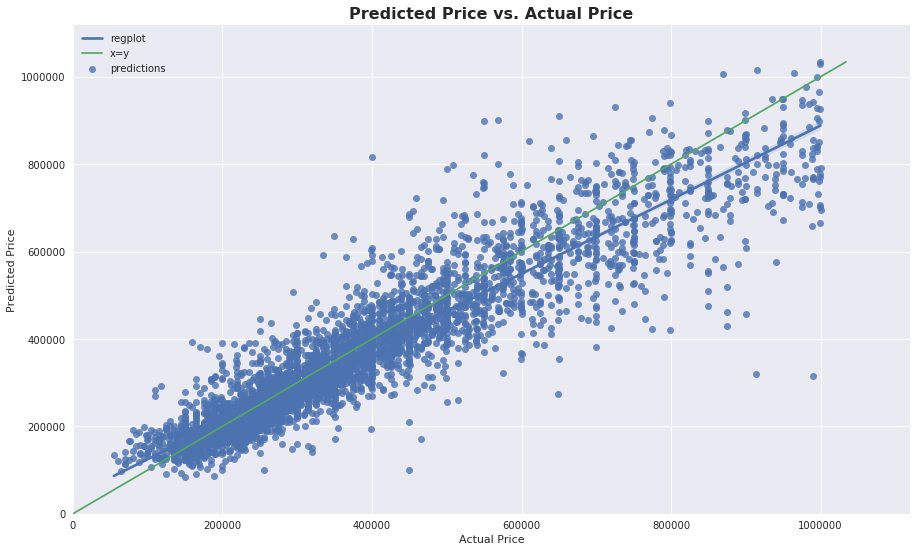

In [32]:
# create fixed actual pred df (add the xgb prediction to the price before averaging)
actual_pred_df_price_fixed = auxiliary.fixed_xgb_actual_pred_error_df(idx_comp_distance,idx_comp_price,target_test, target_train, 'price')
# 9.6
importlib.reload(auxiliary)
auxiliary.plot_actual_pred(actual_pred_df_price_fixed)

We received an MdAPE of 10.216% when predicting 5065 home prices



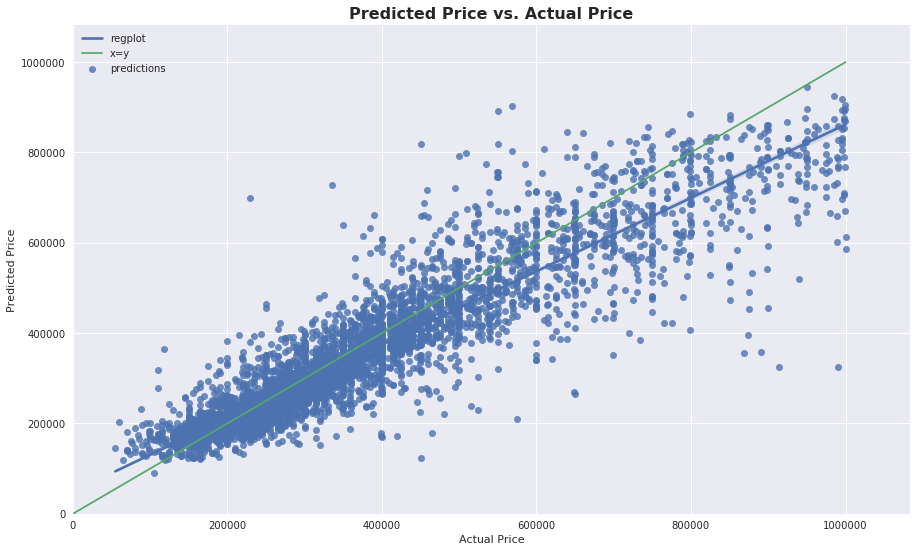

In [33]:
# create actual pred df(without the xgb fix)
actual_pred_df_price = auxiliary.actual_pred_error_df(idx_comp_price,target_test, target_train, 'price')
auxiliary.plot_actual_pred(actual_pred_df_price)